✓ Loaded VQ-VAE (K=256, D=64, Hid=128, ResL=2, ResH=32)
Latent spatial size: 16x16
✓ PixelCNN loaded. layers=10, hidden=96
Using image: /content/input_image.png
Sampling masked latents (temperature=0.8)...


Inpainting progress: 100%|██████████| 256/256 [00:00<00:00, 456.35it/s]


✓ Saved result: ./results/inpainting_20251026_040837.png


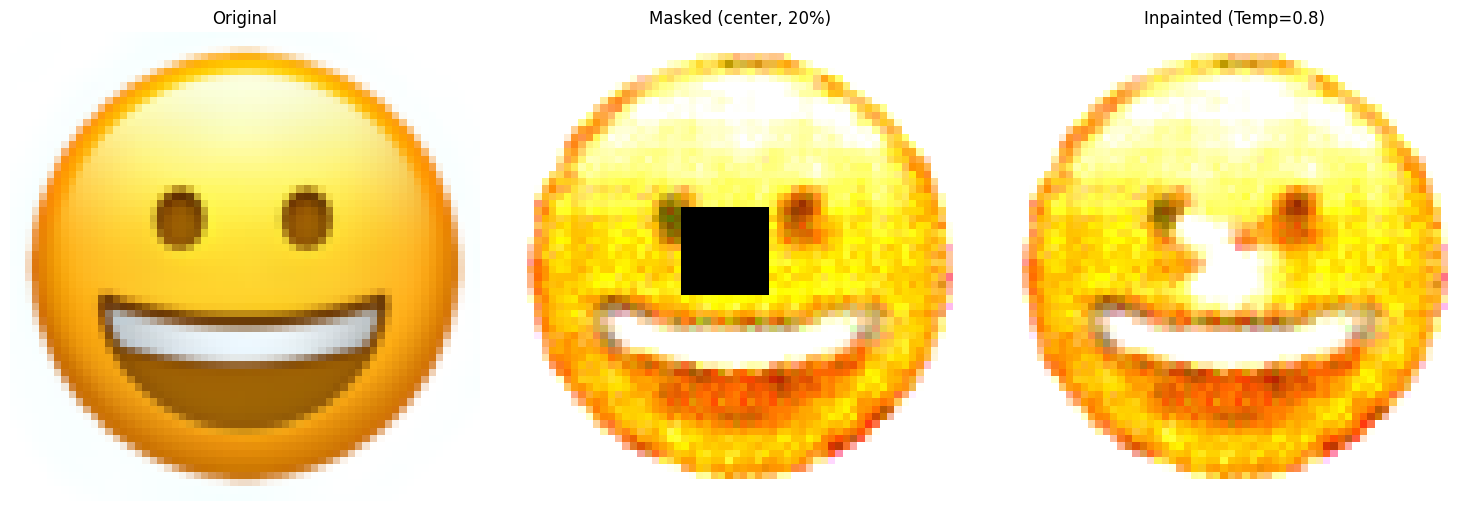

In [20]:
# === Phase 3: Inpainting (uses ONLY your .pt checkpoints, no torchvision) ===
# Checkpoints:
#   /mnt/data/vqvae_final.pt   (VQ-VAE)
#   /mnt/data/prior_final.pt   (PixelCNN prior)

import os
from datetime import datetime
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VQVAE_CKPT = "/content/vqvae_final.pt"
PRIOR_CKPT = "/content/prior_final.pt"

# Set an input image (any size; will be resized to vqvae.image_size)
IMAGE_PATH = "/content/input_image.png"  # e.g., "./sample.png"
RESULTS_DIR = "./results"; os.makedirs(RESULTS_DIR, exist_ok=True)

# --------- tiny helpers to avoid torchvision ----------
def pil_to_normalized_tensor(img, size_hw, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    """Resize to (H,W), convert to float tensor in [-1,1] with given mean/std."""
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize(size_hw[::-1], Image.BILINEAR)  # size expects (W,H); we pass (H,W) reversed
    arr = np.asarray(img).astype(np.float32) / 255.0  # H,W,3 in [0,1]
    t = torch.from_numpy(arr).permute(2,0,1)          # 3,H,W
    mean_t = torch.tensor(mean, dtype=torch.float32).view(3,1,1)
    std_t  = torch.tensor(std,  dtype=torch.float32).view(3,1,1)
    t = (t - mean_t) / std_t                          # normalize
    return t.unsqueeze(0).to(DEVICE)                  # 1,3,H,W

def denorm_to_numpy(img_t, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    """Tensor (1,3,H,W) in normalized space -> H,W,3 in [0,1] numpy."""
    t = img_t.squeeze(0).detach().cpu()               # 3,H,W
    mean_t = torch.tensor(mean).view(3,1,1)
    std_t  = torch.tensor(std).view(3,1,1)
    t = t * std_t + mean_t
    arr = t.permute(1,2,0).numpy()
    return np.clip(arr, 0.0, 1.0)

# -----------------------------
# VQ-VAE (checkpoint-compatible)
# -----------------------------
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        embed = torch.randn(num_embeddings, embedding_dim)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(num_embeddings))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, inputs):
        B, D, H, W = inputs.shape
        flat = inputs.permute(0,2,3,1).contiguous().view(-1, D)
        distances = (torch.sum(flat**2, dim=1, keepdim=True)
                     + torch.sum(self.embed**2, dim=1)
                     - 2 * torch.matmul(flat, self.embed.t()))
        idx = torch.argmin(distances, dim=1)
        onehot = F.one_hot(idx, self.num_embeddings).float()
        quant = torch.matmul(onehot, self.embed)
        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(onehot.sum(0), alpha=1-self.decay)
            dw = torch.matmul(onehot.t(), flat)
            self.embed_avg.data.mul_(self.decay).add_(dw, alpha=1-self.decay)
            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.epsilon) /
                            (n + self.num_embeddings*self.epsilon) * n)
            embed_norm = self.embed_avg / cluster_size.unsqueeze(1)
            self.embed.data.copy_(embed_norm)
        e_latent = F.mse_loss(quant.detach(), flat)
        loss = self.commitment_cost * e_latent
        quant = flat + (quant - flat).detach()
        quant = quant.view(B, H, W, D).permute(0,3,1,2).contiguous()
        return quant, loss, torch.tensor(0.0, device=inputs.device), idx

class ResidualBN(nn.Module):
    # Matches checkpoint keys:
    # residual_stack.layers.N.block.1 (Conv) / .2 (BN) / .3 (ReLU) / .4 (Conv) / .5 (BN)
    def __init__(self, channels, hidden_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Identity(),                                 # 0 placeholder to match indices
            nn.Conv2d(channels, hidden_channels, 3, 1, 1), # 1
            nn.BatchNorm2d(hidden_channels),               # 2
            nn.ReLU(inplace=True),                         # 3
            nn.Conv2d(hidden_channels, channels, 1, 1, 0), # 4
            nn.BatchNorm2d(channels),                      # 5
        )
    def forward(self, x):
        y = self.block[1](x); y = self.block[2](y); y = self.block[3](y)
        y = self.block[4](y); y = self.block[5](y)
        return F.relu(x + y, inplace=True)

class ResidualStackBN(nn.Module):
    def __init__(self, channels, hidden_channels, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([ResidualBN(channels, hidden_channels) for _ in range(num_layers)])
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

class EncoderCompat(nn.Module):
    # Keys in checkpoint: encoder.conv1 / conv2 / conv3 / residual_stack.layers.*
    def __init__(self, in_channels, num_hiddens, num_res_layers, num_res_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_hiddens//2, 4, 2, 1)  # 64->32
        self.conv2 = nn.Conv2d(num_hiddens//2, num_hiddens, 4, 2, 1)  # 32->16
        self.conv3 = nn.Conv2d(num_hiddens, num_hiddens, 3, 1, 1)
        self.residual_stack = ResidualStackBN(num_hiddens, num_res_hiddens, num_res_layers)
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = self.conv3(x)
        x = self.residual_stack(x)
        return x

class DecoderCompat(nn.Module):
    # Keys in checkpoint: decoder.conv1 / residual_stack.layers.* / conv_trans1 / conv_trans2
    def __init__(self, out_channels, num_hiddens, num_res_layers, num_res_hiddens, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(embedding_dim, num_hiddens, 3, 1, 1)
        self.residual_stack = ResidualStackBN(num_hiddens, num_res_hiddens, num_res_layers)
        self.conv_trans1 = nn.ConvTranspose2d(num_hiddens, num_hiddens//2, 4, 2, 1)  # 16->32
        self.conv_trans2 = nn.ConvTranspose2d(num_hiddens//2, out_channels, 4, 2, 1) # 32->64
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.residual_stack(x)
        x = F.relu(self.conv_trans1(x), inplace=True)
        x = self.conv_trans2(x)
        return x

class VQVAE_Compat(nn.Module):
    def __init__(self, image_size, num_hiddens, num_residual_layers, num_residual_hiddens,
                 embedding_dim, num_embeddings, commitment_cost, decay):
        super().__init__()
        self.image_size = int(image_size)
        self.encoder = EncoderCompat(3, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.pre_vq_conv = nn.Conv2d(num_hiddens, embedding_dim, 1)
        self.vq = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        self.decoder = DecoderCompat(3, num_hiddens, num_residual_layers, num_residual_hiddens, embedding_dim)
    @torch.no_grad()
    def encode(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        _, _, _, idx = self.vq(z)
        B, D, H, W = z.shape
        return idx.view(B, H, W)

# -------------------------
# Infer VQ-VAE dims safely
# -------------------------
def infer_vqvae_dims_from_state_dict(sd):
    # num_embeddings, embedding_dim
    K, D = sd["vq.embed"].shape
    # num_hiddens from encoder.conv2 out channels
    num_hiddens = int(sd["encoder.conv2.weight"].shape[0])
    # residual layers count
    max_res_idx = -1
    for k in sd.keys():
        if k.startswith("encoder.residual_stack.layers."):
            try:
                i = int(k.split(".")[3])
                max_res_idx = max(max_res_idx, i)
            except: pass
    num_residual_layers = max_res_idx + 1 if max_res_idx >= 0 else 0
    # num_residual_hiddens from first residual block conv weight: [hidden, in_ch, 3,3]
    num_residual_hiddens = int(sd["encoder.residual_stack.layers.0.block.1.weight"].shape[0])
    # commitment_cost / decay may not be in state_dict; use common defaults
    commitment_cost = 0.01
    decay = 0.95
    # image_size doesn't affect loading; assume 64 (typical)
    image_size = 64
    return {
        "image_size": image_size,
        "num_hiddens": num_hiddens,
        "num_residual_layers": num_residual_layers,
        "num_residual_hiddens": num_residual_hiddens,
        "embedding_dim": D,
        "num_embeddings": K,
        "commitment_cost": commitment_cost,
        "decay": decay,
    }

def load_vqvae_from_ckpt(ckpt_path):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"VQ-VAE checkpoint not found: {ckpt_path}")
    blob = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
    sd = blob.get("model_state_dict", blob)
    dims = infer_vqvae_dims_from_state_dict(sd)
    vqvae = VQVAE_Compat(**dims).to(DEVICE)
    vqvae.load_state_dict(sd, strict=False) # Changed strict=True to strict=False
    print(f"✓ Loaded VQ-VAE (K={dims['num_embeddings']}, D={dims['embedding_dim']}, "
          f"Hid={dims['num_hiddens']}, ResL={dims['num_residual_layers']}, ResH={dims['num_residual_hiddens']})")
    return vqvae, dims

# -------------------------
# PixelCNN Prior (auto-detect)
# -------------------------
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        k = self.kernel_size[0]
        self.mask[:, :, :k//2, :] = 1
        self.mask[:, :, k//2, :k//2] = 1
        if mask_type == 'B':
            self.mask[:, :, k//2, k//2] = 1
    def forward(self, x):
        return F.conv2d(x, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class GatedResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = MaskedConv2d('B', hidden_dim, hidden_dim*2, 3, padding=1)
        self.conv2 = MaskedConv2d('B', hidden_dim, hidden_dim, 1)
    def forward(self, x):
        h = self.conv1(F.relu(x))
        h1, h2 = h.chunk(2, dim=1)
        h = torch.tanh(h1) * torch.sigmoid(h2)
        h = self.conv2(h)
        return x + h

class ImprovedPixelCNN(nn.Module):
    def __init__(self, num_embeddings, spatial_h, spatial_w, num_layers, hidden_dim):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.spatial_h = spatial_h
        self.spatial_w = spatial_w
        self.input_conv = nn.Sequential(
            MaskedConv2d('A', num_embeddings, hidden_dim, 7, padding=3),
            nn.ReLU()
        )
        self.residual_blocks = nn.ModuleList([GatedResidualBlock(hidden_dim) for _ in range(num_layers)])
        self.output = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, num_embeddings, 1)
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, MaskedConv2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_onehot = F.one_hot(x, self.num_embeddings).float().permute(0,3,1,2).contiguous()
        h = self.input_conv(x_onehot)
        for blk in self.residual_blocks: h = blk(h)
        return self.output(h)

def infer_prior_arch_from_state_dict(sd):
    # hidden_dim from input_conv.0.weight out_channels
    key = "input_conv.0.weight"
    if key not in sd:
        for k in sd:
            if k.endswith("input_conv.0.weight"):
                key = k; break
    hidden_dim = int(sd[key].shape[0])
    # num_layers from residual_blocks.N.*
    max_idx = -1
    for k in sd:
        if k.startswith("residual_blocks."):
            try:
                i = int(k.split(".")[1])
                max_idx = max(max_idx, i)
            except: pass
    num_layers = max_idx + 1 if max_idx >= 0 else 0
    return num_layers, hidden_dim

def load_prior_from_ckpt(ckpt_path, num_embeddings, H, W):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"PixelCNN checkpoint not found: {ckpt_path}")
    blob = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
    sd = blob.get("model_state_dict", blob)
    layers, hidden = infer_prior_arch_from_state_dict(sd)
    prior = ImprovedPixelCNN(num_embeddings=num_embeddings, spatial_h=H, spatial_w=W,
                             num_layers=layers, hidden_dim=hidden).to(DEVICE)
    prior.load_state_dict(sd, strict=True)
    print(f"✓ Loaded PixelCNN prior (layers={layers}, hidden={hidden})")
    return prior

# -------------------------
# Helpers
# -------------------------
@torch.no_grad()
def latent_size(vqvae, image_size):
    dummy = torch.randn(1,3,image_size,image_size, device=DEVICE)
    enc = vqvae.encoder(dummy)
    return int(enc.shape[2]), int(enc.shape[3])

@torch.no_grad()
def decode_from_codes(vqvae, codes, H, W):
    B = codes.shape[0]
    flat = codes.view(-1)
    quant = F.embedding(flat, vqvae.vq.embed)
    quant = quant.view(B, H, W, -1).permute(0,3,1,2).contiguous()
    return vqvae.decoder(quant)

# -------------------------
# Inpainting core
# -------------------------
@torch.no_grad()
def inpaint_image(image_path, vqvae, prior, image_size=64, mask_type='center', mask_ratio=0.5, temperature=1.0):
    vqvae.eval(); prior.eval()
    img = Image.open(image_path).convert('RGB')
    x = pil_to_normalized_tensor(img, (image_size, image_size))  # 1,3,H,W in [-1,1]

    codes = vqvae.encode(x)   # (1,Hc,Wc)
    Hc, Wc = codes.shape[1:]

    # Mask in latent space (True = keep original; False = inpaint)
    mask = torch.ones_like(codes, dtype=torch.bool, device=DEVICE)
    mh, mw = int(Hc*mask_ratio), int(Wc*mask_ratio)
    if mask_type == 'center':
        hs, ws = (Hc-mh)//2, (Wc-mw)//2
        mask[:, hs:hs+mh, ws:ws+mw] = False
    elif mask_type == 'top':
        mask[:, :mh, :] = False
    elif mask_type == 'bottom':
        mask[:, Hc-mh:, :] = False
    elif mask_type == 'left':
        mask[:, :, :mw] = False
    elif mask_type == 'right':
        mask[:, :, Wc-mw:] = False
    elif mask_type == 'random':
        nmask = int(Hc*Wc*mask_ratio*mask_ratio)
        nmask = max(0, min(nmask, Hc*Wc))
        if nmask > 0:
            flat = torch.randperm(Hc*Wc, device=DEVICE)[:nmask]
            mask.view(-1)[flat] = False
    else:
        hs, ws = (Hc-mh)//2, (Wc-mw)//2
        mask[:, hs:hs+mh, ws:ws+mw] = False

    print(f"Sampling masked latents (temperature={temperature})...")
    state = codes.clone()
    pbar = tqdm(total=Hc*Wc, desc="Inpainting progress")
    for i in range(Hc):
        for j in range(Wc):
            if not mask[:, i, j]:
                logits = prior(state)[:, :, i, j] / max(1e-6, temperature)
                probs = F.softmax(logits, dim=1)
                sample = torch.multinomial(probs, 1).squeeze(-1)
                state[:, i, j] = sample[0]
            pbar.update(1)
    pbar.close()

    x_inpaint = decode_from_codes(vqvae, state, Hc, Wc)
    x_orig    = decode_from_codes(vqvae, codes, Hc, Wc)

    # Visualize masked region in image space
    img_mask = F.interpolate(mask.float().unsqueeze(1), size=(image_size, image_size), mode='nearest').squeeze(1).bool()
    img_mask = img_mask.unsqueeze(1).expand(-1,3,-1,-1)
    x_masked = x_orig.clone(); x_masked[~img_mask] = -1.0

    return x, x_masked, x_inpaint

def main():
    # Load VQ-VAE from your .pt
    vq_blob = torch.load(VQVAE_CKPT, map_location=DEVICE, weights_only=False)
    vq_sd = vq_blob.get("model_state_dict", vq_blob)
    dims = infer_vqvae_dims_from_state_dict(vq_sd)
    vqvae = VQVAE_Compat(**dims).to(DEVICE)
    vqvae.load_state_dict(vq_sd, strict=False) # Changed strict=True to strict=False
    print(f"✓ Loaded VQ-VAE (K={dims['num_embeddings']}, D={dims['embedding_dim']}, "
          f"Hid={dims['num_hiddens']}, ResL={dims['num_residual_layers']}, ResH={dims['num_residual_hiddens']})")

    # Latent grid size (Hc x Wc)
    Hc, Wc = latent_size(vqvae, dims["image_size"])
    print(f"Latent spatial size: {Hc}x{Wc}")

    # Load PixelCNN prior (num_embeddings must match VQ-VAE codebook K)
    pr_blob = torch.load(PRIOR_CKPT, map_location=DEVICE, weights_only=False)
    pr_sd = pr_blob.get("model_state_dict", pr_blob)
    layers, hidden = infer_prior_arch_from_state_dict(pr_sd)
    prior = ImprovedPixelCNN(num_embeddings=dims["num_embeddings"], spatial_h=Hc, spatial_w=Wc,
                             num_layers=layers, hidden_dim=hidden).to(DEVICE)
    prior.load_state_dict(pr_sd, strict=True)
    print(f"✓ PixelCNN loaded. layers={layers}, hidden={hidden}")

    # Pick image
    global IMAGE_PATH
    if IMAGE_PATH is None:
        cand = [f for f in os.listdir(".") if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".webp"))]
        if not cand:
            raise FileNotFoundError("No IMAGE_PATH set and no image found in current directory.")
        IMAGE_PATH = cand[0]
    print(f"Using image: {IMAGE_PATH}")

    # Inpainting settings
    mask_type = 'center'   # 'center'|'top'|'bottom'|'left'|'right'|'random'
    mask_ratio = 0.2
    temperature = 0.8 # Adjusted temperature

    orig_t, masked_t, result_t = inpaint_image(
        IMAGE_PATH, vqvae, prior,
        image_size=dims["image_size"], mask_type=mask_type, mask_ratio=mask_ratio, temperature=temperature
    )

    # Show & save
    orig   = denorm_to_numpy(orig_t)
    masked = denorm_to_numpy(masked_t)
    res    = denorm_to_numpy(result_t)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(orig);   plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(masked); plt.title(f"Masked ({mask_type}, {int(mask_ratio*100)}%)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(res);    plt.title(f"Inpainted (Temp={temperature})"); plt.axis('off')
    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, f"inpainting_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved result: {out_path}")
    plt.show()

if __name__ == "__main__":
    if not os.path.exists(VQVAE_CKPT):
        raise FileNotFoundError(f"Missing VQ-VAE checkpoint at {VQVAE_CKPT}")
    if not os.path.exists(PRIOR_CKPT):
        raise FileNotFoundError(f"Missing PixelCNN checkpoint at {PRIOR_CKPT}")
    main()

In [11]:
# Select the first image from the training dataset
selected_image = train_dataset[0]["image"]

# Save the image to a file
image_filename = "input_image.png"
selected_image.save(image_filename)

print(f"Saved '{train_dataset[0]['text']}' as '{image_filename}'")

Saved 'grinning face' as 'input_image.png'


In [8]:
!pip install datasets

Image Name: man getting face massage type 4


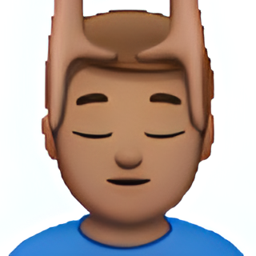

Image Name: father christmas


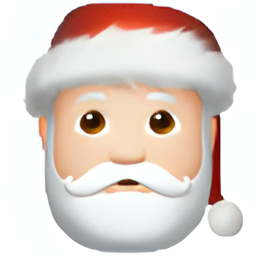

Image Name: capricorn


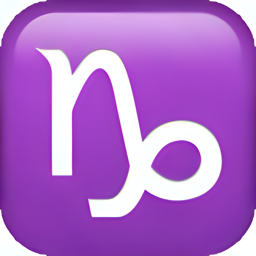

Image Name: merperson


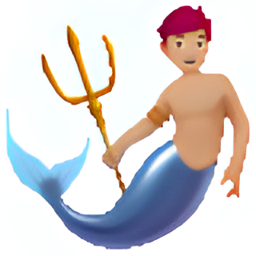

Image Name: male judge


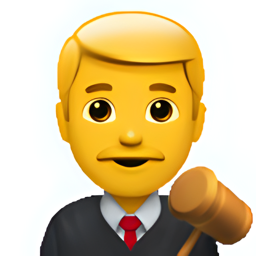

In [10]:
from datasets import load_dataset
import random

# Load the emoji dataset
dataset = load_dataset("valhalla/emoji-dataset")

# Access the training split (or choose another split if available)
train_dataset = dataset["train"]

# Display a few random images from the dataset
num_examples = 5
random_indices = random.sample(range(len(train_dataset)), num_examples)

for i in random_indices:
    example = train_dataset[i]
    image = example["image"]
    name = example["text"]

    print(f"Image Name: {name}")
    display(image)

# You can access a specific image by its index, for example:
# first_image = train_dataset[0]["image"]
# display(first_image)